In [305]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tarfile
import glob
from matplotlib.colors import LogNorm
import pathlib

In [306]:
# Inputs ETH
run_type = 'ov'

if run_type == 'brca':
   
    sample_target = 'TCGA-AO-A0JM-01A-21R-A056-07'
    basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
elif run_type == 'ov':
    sample_target = 'TCGA-25-1319-01A-01R-1565-13'
    basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'

filtering_id = 'filters_22March_order_wany_wAnnot'
filter_dir = os.path.join(basedir, 'filtering_samples', filtering_id)


# PLOT
plot_dir = os.path.join(filter_dir, 'plots')
base_plot = sample_target
pathlib.Path(plot_dir).mkdir(parents=True, exist_ok=True)

# OHSU
tar_file_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/include_ANY_filters_OHSU-results_March22-2023/OHSU_March27-2023_fixAnyfilters_results.tar.gz'


In [307]:
# ETH Names
eth_all = glob.glob(os.path.join(filter_dir, 'G*'))

In [308]:
# OHSU Names
with tarfile.open(tar_file_OHSU, "r:*") as tar:
    ohsu_all = tar.getnames()

In [309]:
# Get file pairs
file_pair = {}
for idx_eth, eth in enumerate(eth_all):
    pattern = os.path.basename(eth).replace('G_', '').replace('.gz', '') 
    for idx_ohsu, ohsu in enumerate(ohsu_all):
        if pattern in ohsu:
            file_pair[eth] = ohsu

            

In [310]:
len(file_pair)

305

# Collect Data to plot

In [311]:
restrict = sample_target
df = {'sample' : [], 
      'filter_foreground' : [], 
      'filter_background' : [], 
      'size_ohsu' : [], 
      'size_eth' : [], 
      'size_intersection' : [], 
      'size_ohsu\eth' : [], 
      'size_eth\ohsu' : []}
with tarfile.open(tar_file_OHSU, "r:*") as tar: #OHSU
    for eth, ohsu in file_pair.items(): # ETH
        if (not restrict) or restrict in eth: #Restrict to category of interest
            try:
                df_ohsu = pd.read_csv(tar.extractfile(ohsu), header=0, sep="\t")
                #print(eth)
                df_eth = pd.read_csv(eth, sep="\t", usecols = ['kmer'])
                #print(df_eth.shape)
                df_eth = set(df_eth['kmer'])
                #print(len(df_eth))
                df_ohsu = set(df_ohsu['kmer'])
                name = os.path.basename(ohsu).replace('.tsv', '').split('_')
                df['sample'].append(name[1])
                df['filter_foreground'].append(name[2])
                df['filter_background'].append(name[3])
                df['size_ohsu'].append(len(df_ohsu))
                df['size_eth'].append(len(df_eth))
                df['size_ohsu\eth'].append(len(df_ohsu.difference(df_eth)))
                df['size_eth\ohsu'].append(len(df_eth.difference(df_ohsu)))
                df['size_intersection'].append(len(df_ohsu.intersection(df_eth)))
            except:
                continue


In [312]:
df = pd.DataFrame(df)

In [313]:
df.shape

(60, 8)

# Path Tests

In [316]:
back_ = set()
foregr_ = set()
for i in eth_all:
    if 'FiltNormalsGtexC' in i:
        if sample_target in i:
            back_.add(os.path.basename(i).split('_')[3])
            foregr_.add(os.path.basename(i).split('_')[2])
print('foreground')
for i in foregr_:
    print(i)
print('background')
for i in back_:
    print(i)

foreground
SampleLim0.0CohortLimNoneAcrossNone
SampleLim0.0CohortLim0.0Across5
SampleLim0.0CohortLim2.0Across1
SampleLim0.0CohortLim0.0Across1
SampleLim0.0CohortLim2.0Across5
background
FiltNormalsGtexCohortCohortlimAnyAcrossAny.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim1.0AcrossAny.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1metadata2.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim0.0AcrossAny.tsv.gz
FiltNormalsGtexCohortCohortlim3.0AcrossAny.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across2.tsv.gz


# Plot Set size

In [326]:
# Extract Values
df['filter_background_reads'] = [float(i.split('lim')[-1].split('Across')[0]) for i in df['filter_background']]

df['filter_background_samples'] = [int(i.split('Across')[-1].replace('Any', '1000')) for i in df['filter_background']]

df['filter_foreground_reads'] = [float(i.split('Lim')[-1].split('Across')[0].replace('None', '0')) for i in df['filter_foreground']]

df['filter_foreground_samples'] = [int(i.split('Across')[-1].replace('None', '0')) for i in df['filter_foreground']]

df['filter_foreground_target'] = [float((i.split('Lim')[1].replace('SampleLim', '').replace('Cohort', ''))) for i in df['filter_foreground']]

In [327]:
# Prepare Plot ticks
def prepare_backticks(x):
    return  [i.replace('FiltNormalsGtexCohortCohortlim', '(').replace('Across', ', ') + ')' 
              for i in x]
def prepare_frontticks(x):
    return  [i.replace('SampleLim0.0CohortLim', '(').replace('Across', ', ') + ')' 
              for i in x]


In [328]:
# Sort Valus for plot
df = df.sort_values(['size_ohsu', 
                     'filter_foreground_target',
                     'filter_foreground_reads', 
                     'filter_foreground_samples', 
                     'filter_background_reads', 
                     'filter_background_samples'
                    ])
df['index'] = np.arange(len(df))


back_ticks = prepare_backticks(df['filter_background'])
front_ticks = prepare_frontticks(df['filter_foreground'])

In [329]:
# Plot Helper
def plot_text(Y, T, position='top', color='black'):
    Y = np.array(Y)
    T = np.array(T)
    Y[np.where(Y > 0 )[0]]
    T[np.where(Y > 0 )[0]]
    change_val = [i for i in np.arange(len(Y) - 1) if Y[i] != Y[i - 1]]    
    weighted = [change_val[i] + (change_val[i+1] - change_val[i]) / 2 for i, x in enumerate(change_val[:-1])]
    X = [np.floor(change_val[i] + (change_val[i+1] - change_val[i]) / 2) for i, x in enumerate(change_val[:-1])]
    Y = Y[np.array(change_val[:-1])]
    T = T[np.array(change_val[:-1])]
    p_prev = 0 
    percent_diff = 20
    
    for x, y, p in zip(X, Y, T):
        if position == 'bottom':
            delta = - (y/5.5)
        elif position == 'top': 
            delta = (y/12)
        if (p > p_prev + (p_prev/percent_diff)) or (p < p_prev - (p_prev/percent_diff)):
            if y != 0: # Because log scale
                plt.text(x - 0.5 , y + delta , p, color=color, ha='left')
        p_prev = p 

def plot_text_all(X, Y, T):
    for x, y, p in zip(X, Y, T):
        plt.text(x, y, p)
        #plt.text(x - 0.5 , y + (y/10), p)


/scratch/slurm-job.874041/ipykernel_3219540/2556945608.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.874041/ipykernel_3219540/2556945608.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
/scratch/slurm-job.874041/ipykernel_3219540/2556945608.py:20: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


save to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_22March_order_wany_wAnnot/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_ovelap.pdf


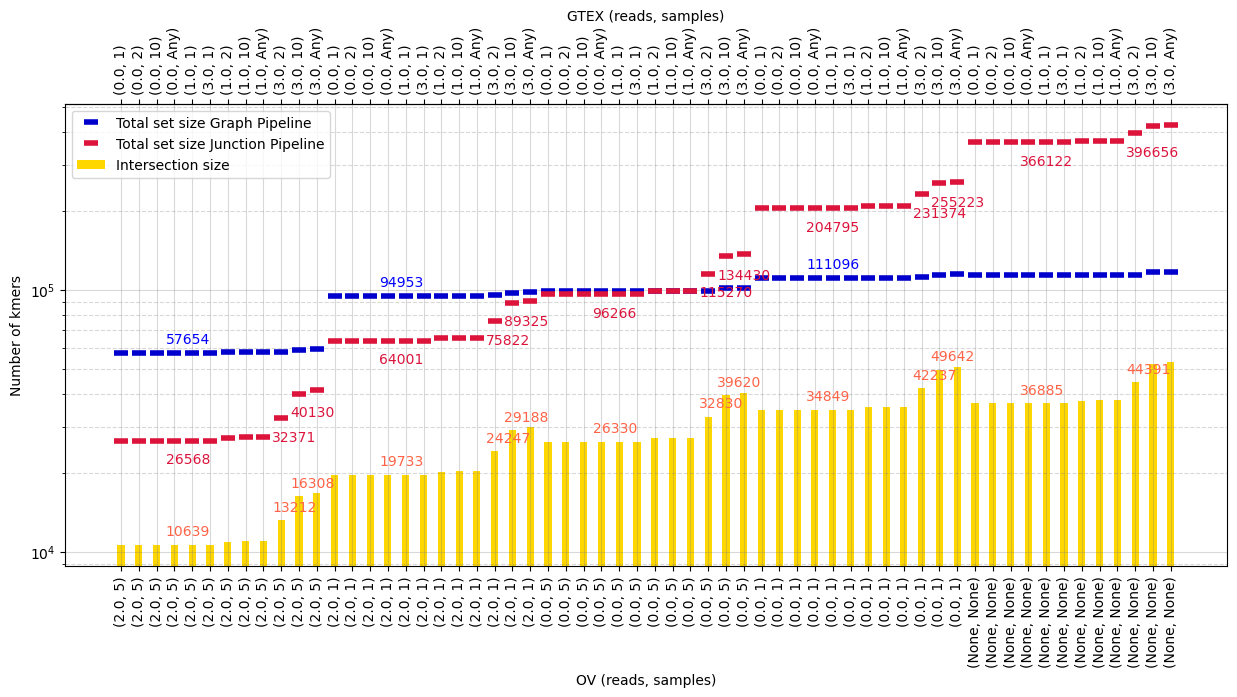

In [332]:
# Plot

xaxis_label = 'GTEX (reads, samples)'
yaxis_label = f'{run_type.upper()} (reads, samples)'


colorgrid = 'grey'
alpha_grid = 0.3
marker_size = 10
mew = 4
color1 = 'gold'
color2 = 'crimson'
color4 = 'mediumblue'
colorgrid = 'grey'

fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 =  ax1.secondary_xaxis('top')   
#plt.figure(figsize=(15, 6), frameon=False, dpi=100)
plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
width = 0.4
plt.bar(df['index'], df['size_intersection'], width=width, 
        color=color1, label='Intersection size')
plt.plot(df['index'], df['size_eth'], alpha=1, color=color4,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Graph Pipeline')
plt.plot(df['index'], df['size_ohsu'], alpha=1, color=color2,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Junction Pipeline')

plot_text(df['size_ohsu'], df['size_ohsu'], 'bottom', color='crimson')
plot_text(df['size_eth'], df['size_eth'], 'top', color='blue')
plot_text(df['size_intersection'], df['size_intersection'], color='tomato')

plt.yscale('log')
max_scale = np.max([df['size_ohsu'].values, df['size_eth'].values])



ax1.set_xticks(np.arange(len(df['index'])), 
           labels = front_ticks,
           rotation = 90, 
           ha = 'center')

ax2.set_xticks(np.arange(len(df['index'])), 
           labels = back_ticks,
           rotation = 90, 
           ha = 'center')

plt.legend()
plt.ylabel('Number of kmers')
ax2.set_xlabel(xaxis_label)
ax1.set_xlabel(yaxis_label)



save = True
name = 'Barplot_ovelap'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
plt.show()

# Plot Intersections

In [333]:
df.columns

Index(['sample', 'filter_foreground', 'filter_background', 'size_ohsu',
       'size_eth', 'size_intersection', 'size_ohsu\eth', 'size_eth\ohsu',
       'filter_background_reads', 'filter_background_samples',
       'filter_foreground_reads', 'filter_foreground_samples',
       'filter_foreground_target', 'index'],
      dtype='object')

In [334]:
# Sort Valus for plot
df = df.sort_values(['size_eth', 
                     'filter_foreground_target',
                     'filter_foreground_reads', 
                     'filter_foreground_samples', 
                     'filter_background_reads', 
                     'filter_background_samples'
                    ], 
                   ascending=[False, False, False, False, False, False])
df['index'] = np.arange(len(df))

order_foreground = df['filter_foreground'].unique()
order_background = df['filter_background'].unique()

In [335]:
# Collect plot data
titles = ['Intersection size', 
'Total set size Graph Pipeline', 
'Total set size Junction Pipeline']
xaxis_label = 'GTEX (reads, samples)'
yaxis_label = f'{run_type.upper()} (reads, samples)'

df_plot = []
for f in ['size_intersection', 'size_eth', 'size_ohsu']: #, 'size_ohsu\eth', 'size_eth\ohsu']:
    # Extract the intersection
    df_inter = df.pivot(index = 'filter_foreground', columns = 'filter_background', values = f )
    # Enforce order
    df_inter = df_inter.loc[order_foreground, order_background]
    df_plot.append(df_inter)
    


In [336]:
df_plot[pane_idx].columns

Index(['FiltNormalsGtexCohortCohortlim3.0AcrossAny',
       'FiltNormalsGtexCohortCohortlim3.0Across10',
       'FiltNormalsGtexCohortCohortlim3.0Across2',
       'FiltNormalsGtexCohortCohortlim1.0AcrossAny',
       'FiltNormalsGtexCohortCohortlim1.0Across10',
       'FiltNormalsGtexCohortCohortlim1.0Across2',
       'FiltNormalsGtexCohortCohortlim3.0Across1',
       'FiltNormalsGtexCohortCohortlim1.0Across1',
       'FiltNormalsGtexCohortCohortlim0.0AcrossAny',
       'FiltNormalsGtexCohortCohortlim0.0Across10',
       'FiltNormalsGtexCohortCohortlim0.0Across2',
       'FiltNormalsGtexCohortCohortlim0.0Across1'],
      dtype='object', name='filter_background')

426326

save to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_22March_order_wany_wAnnot/plots/TCGA-25-1319-01A-01R-1565-13_Matrix_ovelap.pdf


/scratch/slurm-job.874041/ipykernel_3219540/4023554690.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


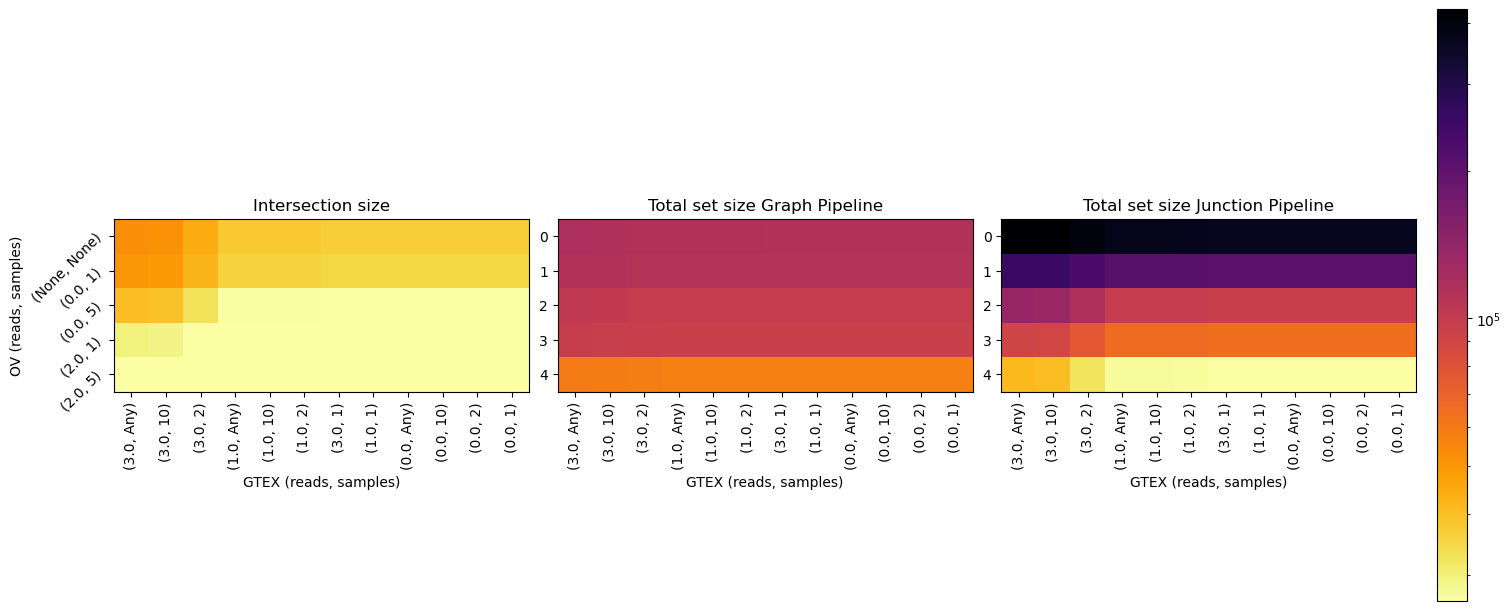

In [347]:
# Plot
nprow = 1
npcol = 3
fig = plt.figure(figsize=(15, 6), layout='constrained')
axes = [fig.add_subplot(nprow, npcol, i) for i in range(1,npcol+1)]

vmin = max(1, np.min([df['size_eth'], df['size_ohsu']]))
vmax = np.max([df['size_eth'], df['size_ohsu']]) #1e5
for pane_idx in np.arange(npcol):
    panelplot=axes[pane_idx].imshow(df_plot[pane_idx], origin='upper', 
                                    cmap='inferno_r', norm=LogNorm(vmin=vmin, vmax=vmax))
    # x-axis 
    axes[pane_idx].set_title(titles[pane_idx])
    axes[pane_idx].set_xlabel(xaxis_label)
    axes[pane_idx].set_xticks(range(df_plot[pane_idx].shape[1]))
    axes[pane_idx].set_xticklabels(prepare_backticks(df_plot[pane_idx].columns), rotation = 90 )
    if pane_idx == 0 :
        # y-axis
        axes[pane_idx].set_ylabel(yaxis_label)
        axes[pane_idx].set_yticks(range(df_plot[pane_idx].shape[0]))
        axes[pane_idx].set_yticklabels(prepare_frontticks(df_plot[pane_idx].index), rotation = 45 )
plt.colorbar(panelplot)

save = True
name = 'Matrix_ovelap'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
fig.show()


In [298]:
df_plot[1]

filter_background,FiltNormalsGtexCohortCohortlim3.0AcrossAny,FiltNormalsGtexCohortCohortlim3.0Across10,FiltNormalsGtexCohortCohortlim3.0Across2,FiltNormalsGtexCohortCohortlim3.0Across1,FiltNormalsGtexCohortCohortlim1.0AcrossAny,FiltNormalsGtexCohortCohortlim1.0Across10,FiltNormalsGtexCohortCohortlim1.0Across2,FiltNormalsGtexCohortCohortlim1.0Across1,FiltNormalsGtexCohortCohortlim0.0AcrossAny,FiltNormalsGtexCohortCohortlim0.0Across10,FiltNormalsGtexCohortCohortlim0.0Across2,FiltNormalsGtexCohortCohortlim0.0Across1
filter_foreground,,,,,,,,,,,,
SampleLim0.0CohortLimNoneAcrossNone,1188,1158,1120,1071,1071,1071,1071,1071,1071,1071,1071,1071
SampleLim0.0CohortLim0.0Across1,607,577,555,534,534,534,534,534,534,534,534,534
SampleLim0.0CohortLim2.0Across1,487,458,443,422,422,422,422,422,422,422,422,422
SampleLim0.0CohortLim0.0Across5,347,327,312,294,294,294,294,294,294,294,294,294
SampleLim0.0CohortLim2.0Across5,199,192,184,166,166,166,166,166,166,166,166,166


In [299]:
df_plot[2]

filter_background,FiltNormalsGtexCohortCohortlim3.0AcrossAny,FiltNormalsGtexCohortCohortlim3.0Across10,FiltNormalsGtexCohortCohortlim3.0Across2,FiltNormalsGtexCohortCohortlim3.0Across1,FiltNormalsGtexCohortCohortlim1.0AcrossAny,FiltNormalsGtexCohortCohortlim1.0Across10,FiltNormalsGtexCohortCohortlim1.0Across2,FiltNormalsGtexCohortCohortlim1.0Across1,FiltNormalsGtexCohortCohortlim0.0AcrossAny,FiltNormalsGtexCohortCohortlim0.0Across10,FiltNormalsGtexCohortCohortlim0.0Across2,FiltNormalsGtexCohortCohortlim0.0Across1
filter_foreground,,,,,,,,,,,,
SampleLim0.0CohortLimNoneAcrossNone,5384,5136,4224,3643,3690,3690,3690,3643,3643,3643,3643,3643
SampleLim0.0CohortLim0.0Across1,1155,907,371,194,200,200,200,194,194,194,194,194
SampleLim0.0CohortLim2.0Across1,556,390,149,71,71,71,71,71,71,71,71,71
SampleLim0.0CohortLim0.0Across5,376,237,75,21,21,21,21,21,21,21,21,21
SampleLim0.0CohortLim2.0Across5,153,111,53,16,16,16,16,16,16,16,16,16
